# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [2]:
!nvidia-smi

Fri Apr 23 10:36:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   22C    P8     5W / 180W |   3407MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [16]:
dataset='CHEMBL205_cl'

In [17]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}.csv')

In [18]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl_ecfp_1024.csv')]

# Generate activations

In [19]:
IMAGES=path/'mol_images'/f'{dataset}'

# Create train validation split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

In [25]:
x_train,x_val = train_test_split(df.index, test_size=0.25, stratify=df['Activity'], 
                                     random_state=42)
df.loc[x_train, 'is_valid']=False
df.loc[x_val, 'is_valid']=True

# Create dataloader

In [26]:
from fastai.vision.all import *

In [27]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,Image,is_valid
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,CHEMBL188002.png,True
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,CHEMBL364127.png,False
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,CHEMBL1683469.png,False
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,CHEMBL52564.png,False
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,CHEMBL21427.png,False


In [28]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None
    )

In [29]:
dls = db.dataloaders(df, bs=64, shuffle_train=True)

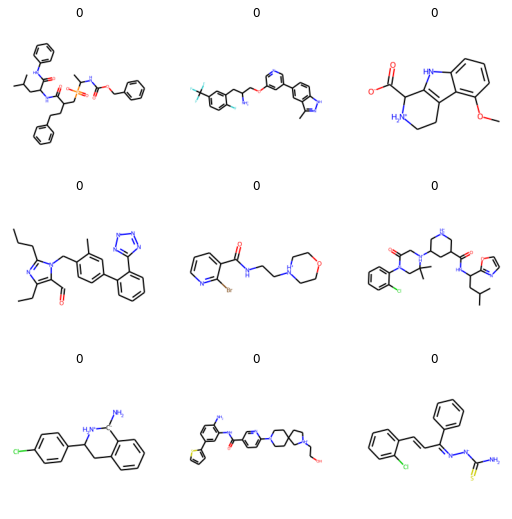

In [30]:
dls.show_batch()

# Train CNN model

In [31]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [32]:
def train_model(dls, arch=resnet18, epochs=6, freeze_epochs=5, wd=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    
    learn = cnn_learner(dls, arch=resnet18, pretrained=True, 
                            wd=wd,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    
    print(f'Finding learning rate...')
    lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
    print(f'Training model with learning rate: {lr_min}')
    learn.fine_tune(epochs, lr_min, freeze_epochs=freeze_epochs)
    
    return learn

In [33]:
# Train model on resnet18
learn = train_model(dls)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7fc82ab47160>
Untrained epochs: freeze_epochs=5
Trained epochs: epochs=6
Finding learning rate...


Training model with learning rate: 0.014454397559165954


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.316155,0.201153,0.931119,0.609355,0.629243,0.590686,0.893801,0.571970,00:35
1,0.210779,0.141031,0.946277,0.674764,0.750751,0.612745,0.953118,0.649770,00:33
2,0.192586,0.155669,0.948506,0.656761,0.833962,0.541667,0.959122,0.647466,00:33
3,0.158814,0.123375,0.959652,0.786808,0.757370,0.818627,0.977237,0.765268,00:33
4,0.137742,0.150996,0.954302,0.708393,0.844068,0.610294,0.976521,0.694898,00:33


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.131968,0.113428,0.956309,0.729282,0.835443,0.647059,0.970748,0.712758,00:42
1,0.132000,0.181391,0.927998,0.387097,0.857143,0.250000,0.964811,0.439871,00:42
2,0.121696,0.135173,0.948952,0.701434,0.749304,0.659314,0.960724,0.675297,00:42
3,0.084639,0.093851,0.963219,0.780293,0.854227,0.718137,0.986940,0.763797,00:42
4,0.044858,0.095345,0.968569,0.823529,0.841432,0.806373,0.984942,0.806506,00:42
5,0.017580,0.102198,0.972358,0.851675,0.831776,0.872549,0.985186,0.836735,00:42


In [34]:
interp = ClassificationInterpretation.from_learner(learn)

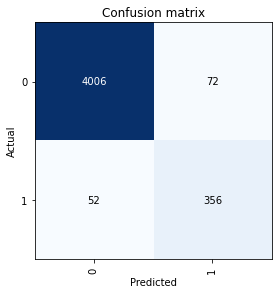

In [35]:
interp.plot_confusion_matrix()

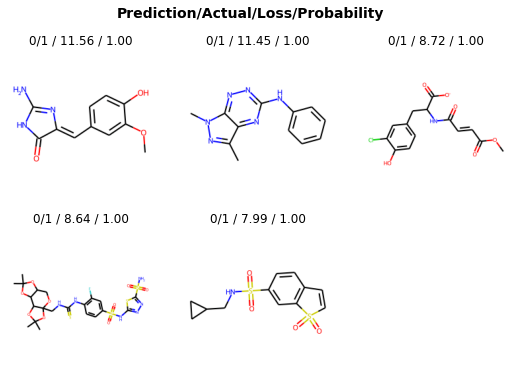

In [36]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [37]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [38]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [39]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [40]:
df_nodupl=df

In [47]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

In [48]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [49]:
test_dls.items.head()

,CID,SMILES,Activity,Image,is_valid
13292,CHEMBL538529,o1nc(cc1C[NH+]1CCN(CC1)c1ccccc1OC(C)C)CN1CCCCC1=O,0,CHEMBL538529.png,False
6115,CHEMBL120871,S(=O)(=O)(NC(Cc1ccc(N)cc1)C(=O)N1CCC(CC1)CCF)C1=CNC=CC1[NH2+]C(Cc1ccccc1)C[NH+](C)C,0,CHEMBL120871.png,False
195,CHEMBL3098531,S1\C(\N(N=C1C(=O)C)c1ccc(S(=O)(=O)N)cc1)=C(\C#N)/C(OCC)=O,1,CHEMBL3098531.png,False
15007,CHEMBL350027,O1N2C(CC13CCCCC3)C(C(C2)C[NH+]1CCC(CC1)c1ccccc1)c1ccccc1,0,CHEMBL350027.png,False
1636,CHEMBL248560,s1cc(nc1-c1cccnc1)-c1ccc(cc1)CC[NH2+]CC(O)c1cccnc1,0,CHEMBL248560.png,True


In [50]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

In [51]:
test_df = test_dls.items.reset_index()

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17941 non-null  int64 
 1   CID       17941 non-null  object
 2   SMILES    17941 non-null  object
 3   Activity  17941 non-null  int64 
 4   Image     17941 non-null  object
 5   is_valid  17941 non-null  object
dtypes: int64(2), object(4)
memory usage: 841.1+ KB


In [53]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Activity  17941 non-null  int64 
 3   Image     17941 non-null  object
 4   is_valid  17941 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.9+ KB


# Check

In [54]:
test_df.loc[test_df.CID == 'CHEMBL1089637']

,index,CID,SMILES,Activity,Image,is_valid
15524,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,CHEMBL1089637.png,False


In [55]:
df_nodupl.loc[df_nodupl.CID == 'CHEMBL1089637']

,CID,SMILES,Activity,Image,is_valid
1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,CHEMBL1089637.png,False


In [56]:
test_dls.dataset

(#17941) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(1)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0))...]

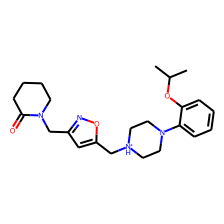

In [57]:
test_dls.dataset[0][0]

In [58]:
test_df.loc[test_df.CID=='CHEMBL1089637']

,index,CID,SMILES,Activity,Image,is_valid
15524,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,1,CHEMBL1089637.png,False


In [59]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [60]:
t_img, t_cat = get_data('CHEMBL1089637')

15524


In [61]:
len(test_dls.dataset)

17941

In [62]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

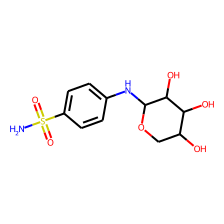

In [63]:
t_img

In [64]:
df_nodupl['activations'] = None

In [65]:
def get_activations(CID, ret=False):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    print(idx)
    data = get_data(CID)
    img = data[0]
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]
    #df_nodupl.iloc[idx]['acts'] = list(acts)
    if not ret: 
        df_nodupl.at[idx, 'activations'] = list(acts)
    if ret: 
        return list(acts)

In [66]:
df_nodupl.CID.values[0]

'CHEMBL188002'

In [67]:
%%capture
for CID in df_nodupl.CID.values:
    get_activations(CID)

In [68]:
df_nodupl.head()

,CID,SMILES,Activity,Image,is_valid,activations
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,CHEMBL188002.png,True,"[20.441788, -34.070347, -55.874096, -46.303505, -36.94316, -32.880577, 56.924206, -21.065784, 100.98068, 25.434101, -27.366495, 50.514477, 22.279602, 13.780892, -61.33496, 51.5019, -82.39697, -59.213398, -25.909046, -40.934708, 41.761215, -78.96105, -50.266132, 47.5966, -46.640957, -50.10497, -36.33068, -45.921204, 44.571804, -42.544792, -30.720026, -29.033741, 23.248016, -22.118792, 14.806098, -47.23298, 45.85109, -68.075584, -38.983734, -45.53679, -41.039043, -33.94125, -37.79083, -12.287365, -21.54076, -0.8218162, -39.225323, 33.397213, -54.33288, -31.158333, -12.660143, -31.700134, -59..."
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,CHEMBL364127.png,False,"[-35.60922, -76.03871, -122.86161, -70.081474, -92.91446, -105.172745, 42.786087, -101.023026, 106.76421, 24.83023, -58.21196, 72.37561, -24.386883, 64.17287, -66.00833, 54.19459, -110.52943, -47.77837, -79.58959, -92.48153, 68.64848, -144.17317, -74.54582, 104.501915, -117.897644, -97.15993, -98.41654, -99.334335, -62.823017, -89.71797, -50.966053, -32.014545, -60.89653, -76.85967, -64.29767, -120.65323, -33.115356, -74.8855, -83.01998, -97.291954, -92.31988, -27.57251, -78.88678, -19.02112, -77.43537, -18.399061, -47.787197, 53.6252, -126.53403, -51.354034, -58.816734, -100.20532, -136.5..."
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,CHEMBL1683469.png,False,"[-72.19954, -79.73292, -145.6987, -81.835724, -115.660416, -127.5523, 40.022156, -119.41521, 110.88527, 40.064434, -72.70248, 91.60647, -38.015022, 85.68369, -78.754135, 59.92734, -125.62406, -48.954712, -105.795265, -115.42396, 88.002655, -181.4998, -88.53843, 133.21863, -150.9004, -122.18439, -126.31767, -127.27838, -104.31726, -106.5082, -63.193306, -26.757238, -99.14134, -104.85434, -82.13036, -150.79893, -51.76007, -90.88706, -99.009346, -117.360466, -119.76474, -33.073982, -102.74929, -17.49065, -94.24532, -38.0294, -55.346317, 57.922554, -155.49355, -65.050415, -67.572586, -116.0627..."
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,CHEMBL52564.png,False,"[-33.640495, -42.489914, -80.051056, -65.76445, -55.754475, -63.614277, 46.954594, -38.22408, 87.1613, 48.764492, -42.982452, 71.60744, -9.838839, 30.381317, -64.548035, 59.9069, -89.63465, -69.76305, -52.906982, -61.743454, 43.851025, -125.996635, -68.18846, 78.80186, -73.34283, -89.14439, -60.68271, -68.85139, -7.1954412, -53.587967, -44.452557, -16.017065, -33.667374, -57.250996, -1.0856264, -77.60109, 13.428894, -82.55813, -53.51783, -71.76159, -75.88027, -40.19798, -62.13004, -4.3708777, -39.762478, -30.058334, -44.56897, 35.67237, -86.6604, -47.44278, -25.278542, -48.670944, -88.1199..."
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,CHEMBL21427.png,False,"[-40.57054, -42.852943, -82.66586, -61.070065, -56.15604, -68.46805, 38.568237, -34.71558, 61.607277, 44.128716, -38.912914, 71.710106, -20.562906, 31.930721, -55.267548, 53.782234, -87.36618, -74.11311, -55.677666, -57.40837, 34.612038, -120.8614, -73.27676, 74.86714, -74.68885, -80.09229, -61.38198, -71.74933, -34.403572, -58.32266, -45.425415, -12.5241375, -47.365665, -58.08107, -9.154864, -78.2698, -8.076019, -71.314285, -53.760323, -69.95956, -78.50262, -36.01127, -59.322395, -5.198322, -41.824165, -37.047935, -40.1027, 32.615498, -87.88623, -46.66415, -18.4444, -52.229774, -88.0478, ..."


In [69]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CID          17941 non-null  object
 1   SMILES       17941 non-null  object
 2   Activity     17941 non-null  int64 
 3   Image        17941 non-null  object
 4   is_valid     17941 non-null  object
 5   activations  17941 non-null  object
dtypes: int64(1), object(5)
memory usage: 841.1+ KB


In [70]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [71]:
df_acts.drop('activations', axis=1, inplace=True)

In [72]:
df_acts.head()

,CID,SMILES,Activity,Image,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,CHEMBL188002.png,True,20.441788,-34.070347,-55.874096,-46.303505,-36.943161,...,-20.266380,-58.616051,-36.874432,-84.006630,-28.130043,-14.237524,-30.243919,-89.924866,-25.477444,-13.185804
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,CHEMBL364127.png,False,-35.609219,-76.038712,-122.861610,-70.081474,-92.914459,...,-27.719458,-79.247879,-71.388512,-117.074829,-87.031128,-25.362850,-91.691391,-97.514877,-159.834167,37.859943
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,CHEMBL1683469.png,False,-72.199539,-79.732918,-145.698700,-81.835724,-115.660416,...,-27.371447,-91.037331,-82.402603,-140.058167,-110.499306,-35.576706,-118.137932,-114.797058,-210.545105,58.341396
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,CHEMBL52564.png,False,-33.640495,-42.489914,-80.051056,-65.764450,-55.754475,...,-12.962411,-65.378036,-52.445572,-105.202003,-54.042187,-23.038553,-45.937416,-107.758331,-74.264862,15.236348
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,CHEMBL21427.png,False,-40.570541,-42.852943,-82.665863,-61.070065,-56.156040,...,-14.881062,-61.484863,-52.275417,-100.329498,-55.440769,-24.665730,-48.966393,-98.103355,-83.055305,20.628500


In [73]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


# Add ECFB to dataframe

In [75]:
df_ecfp = pd.read_csv(path/'CHEMBL205_cl_ecfp_1024.csv')

In [76]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 140.6+ MB


In [78]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


In [79]:
df = df_ecfp.merge(df_acts, on='CID')

In [80]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,-20.266380,-58.616051,-36.874432,-84.006630,-28.130043,-14.237524,-30.243919,-89.924866,-25.477444,-13.185804
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,-27.719458,-79.247879,-71.388512,-117.074829,-87.031128,-25.362850,-91.691391,-97.514877,-159.834167,37.859943
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,-27.371447,-91.037331,-82.402603,-140.058167,-110.499306,-35.576706,-118.137932,-114.797058,-210.545105,58.341396
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,-12.962411,-65.378036,-52.445572,-105.202003,-54.042187,-23.038553,-45.937416,-107.758331,-74.264862,15.236348
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-14.881062,-61.484863,-52.275417,-100.329498,-55.440769,-24.665730,-48.966393,-98.103355,-83.055305,20.628500


In [81]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [82]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,-20.266380,-58.616051,-36.874432,-84.006630,-28.130043,-14.237524,-30.243919,-89.924866,-25.477444,-13.185804
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,-27.719458,-79.247879,-71.388512,-117.074829,-87.031128,-25.362850,-91.691391,-97.514877,-159.834167,37.859943
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,-27.371447,-91.037331,-82.402603,-140.058167,-110.499306,-35.576706,-118.137932,-114.797058,-210.545105,58.341396
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,-12.962411,-65.378036,-52.445572,-105.202003,-54.042187,-23.038553,-45.937416,-107.758331,-74.264862,15.236348
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-14.881062,-61.484863,-52.275417,-100.329498,-55.440769,-24.665730,-48.966393,-98.103355,-83.055305,20.628500


In [84]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [86]:
df.is_valid.value_counts()

False    13455
True      4486
Name: is_valid, dtype: int64

In [85]:
df.to_csv(path/'chembl205-data-with-ecfp-activations.csv', index=None)